In [1]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import os

In [3]:
data_dir = 'DevanagariHandwrittenCharacterDataset'
train_dir = os.path.join(data_dir, 'Train/')
test_dir = os.path.join(data_dir, 'Test/')

In [4]:
classes = os.listdir(train_dir)
print(len(classes))
classes

46


['character_10_yna',
 'character_11_taamatar',
 'character_12_thaa',
 'character_13_daa',
 'character_14_dhaa',
 'character_15_adna',
 'character_16_tabala',
 'character_17_tha',
 'character_18_da',
 'character_19_dha',
 'character_1_ka',
 'character_20_na',
 'character_21_pa',
 'character_22_pha',
 'character_23_ba',
 'character_24_bha',
 'character_25_ma',
 'character_26_yaw',
 'character_27_ra',
 'character_28_la',
 'character_29_waw',
 'character_2_kha',
 'character_30_motosaw',
 'character_31_petchiryakha',
 'character_32_patalosaw',
 'character_33_ha',
 'character_34_chhya',
 'character_35_tra',
 'character_36_gya',
 'character_3_ga',
 'character_4_gha',
 'character_5_kna',
 'character_6_cha',
 'character_7_chha',
 'character_8_ja',
 'character_9_jha',
 'digit_0',
 'digit_1',
 'digit_2',
 'digit_3',
 'digit_4',
 'digit_5',
 'digit_6',
 'digit_7',
 'digit_8',
 'digit_9']

In [5]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=train_transform)

print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  78200
Num test images:  13800


In [6]:
batch_size = 32
valid_size = 0.10

num_train = len(train_data)
split_point = int(valid_size * num_train)

indices = list(range(num_train))
np.random.shuffle(indices)

valid_indices = indices[:split_point]
train_indices = indices[split_point:]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [8]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([32, 3, 32, 32])

In [9]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([32, 3, 32, 32])

In [10]:
torch.cuda.is_available()

False

In [11]:
def output(input_volume, kernel_size, padding, stride=1):
    return ((input_volume - kernel_size + 2 * padding)/stride) + 1

input_size = 32
print("Input image is of size: {}x{}".format(input_size, input_size))
print("First Conv sees: {}x{}".format(input_size, input_size))
input_size = output(input_volume=input_size, kernel_size=5, padding=0, stride=1)
print("Second Conv sees: {}x{}".format(input_size, input_size))
input_size = output(input_volume=input_size, kernel_size=5, padding=0, stride=1)
print("Third Conv sees: {}x{}".format(input_size, input_size))
input_size = output(input_volume=input_size, kernel_size=5, padding=0, stride=1)
print("Fourth Conv sees: {}x{}".format(input_size, input_size))

Input image is of size: 32x32
First Conv sees: 32x32
Second Conv sees: 28.0x28.0
Third Conv sees: 24.0x24.0
Fourth Conv sees: 20.0x20.0


In [3]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, 
                    kernel_size=5, stride=1, padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, 
                    kernel_size=5, stride=1, padding=0)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, 
                    kernel_size=5, stride=1, padding=0)
        
        self.fc1 = nn.Linear(20*20*64, 1000)
        self.fc2 = nn.Linear(1000, 46)
        self.dropout = nn.Dropout(p=0.25)
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 20*20*64)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [13]:
dhcd_model = Network()

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dhcd_model.parameters(), lr=0.001, momentum=0.9)
train_on_gpu = True if torch.cuda.is_available() else False

In [17]:
n_epochs = 55
train_losses = []
valid_losses = []
valid_loss_min = np.inf

for e in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    
    dhcd_model.train()
    
    for img, label in train_loader:
        
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        
        optimizer.zero_grad()
        
        predicted_label = dhcd_model(img)
        loss = criterion(predicted_label, label)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
    
    dhcd_model.eval()
    
    for img, label in valid_loader:
        
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        predicted_label = dhcd_model(img)
        loss = criterion(predicted_label, label)
        
        valid_loss = valid_loss + loss.item()
    
    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(valid_loader)
    valid_losses.append(valid_loss)
    
    print("Epoch: {} Train Loss: {} Valid Loss: {}".format(e+1, train_loss, valid_loss))
    
    if valid_loss < valid_loss_min:
        print("Validation Loss Decreased From {} to {}".format(valid_loss_min, valid_loss))
        valid_loss_min = valid_loss
        torch.save(dhcd_model.state_dict(), "dhcd_model_8_March_2020.pth")
        print("Saving Best Model")

Epoch: 1 Train Loss: 2.850738523873416 Valid Loss: 1.6882678657161947
Validation Loss Decreased From inf to 1.6882678657161947
Saving Best Model
Epoch: 2 Train Loss: 1.3279048346795819 Valid Loss: 0.8381031791774594
Validation Loss Decreased From 1.6882678657161947 to 0.8381031791774594
Saving Best Model
Epoch: 3 Train Loss: 0.8291808844357729 Valid Loss: 0.5765961568574516
Validation Loss Decreased From 0.8381031791774594 to 0.5765961568574516
Saving Best Model
Epoch: 4 Train Loss: 0.6253918526118452 Valid Loss: 0.4411603059999797
Validation Loss Decreased From 0.5765961568574516 to 0.4411603059999797
Saving Best Model
Epoch: 5 Train Loss: 0.516285762143406 Valid Loss: 0.37547913151127954
Validation Loss Decreased From 0.4411603059999797 to 0.37547913151127954
Saving Best Model
Epoch: 6 Train Loss: 0.44193765697831455 Valid Loss: 0.3263103891316117
Validation Loss Decreased From 0.37547913151127954 to 0.3263103891316117
Saving Best Model
Epoch: 7 Train Loss: 0.3913433186608282 Valid L

KeyboardInterrupt: 

In [18]:
n_epochs = 50
avg_accuracy = 0
total_accuracy = 0
test_loss = 0
accuracy = 0
dhcd_model.eval()

for epoch in range(n_epochs):
    
    for img, label in test_loader:
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        predicted_label = dhcd_model(img)
        loss = criterion(predicted_label, label)
        test_loss = test_loss + loss.item()

        top_probab, top_label = predicted_label.topk(1, dim=1)
        equals = top_label == label.view(*top_label.shape)
        accuracy = accuracy + torch.mean(equals.type(torch.FloatTensor))

    test_loss = test_loss/len(test_loader)
    accuracy = accuracy/len(test_loader)
    total_accuracy = total_accuracy + accuracy

    print("Epoch: {} Test Loss: {} Accuracy: {}".format(epoch+1, test_loss, accuracy))

avg_accuracy = total_accuracy/(n_epochs) * 100
print("______________________\nAverage Accuracy: {:.3f}%\n______________________".format(avg_accuracy))

Epoch: 1 Test Loss: 0.1474130958684125 Accuracy: 0.9542100429534912
Epoch: 2 Test Loss: 0.1409294104991309 Accuracy: 0.9585890769958496
Epoch: 3 Test Loss: 0.14850757520004404 Accuracy: 0.9568630456924438
Epoch: 4 Test Loss: 0.14101271765857 Accuracy: 0.9581611156463623
Epoch: 5 Test Loss: 0.14060217309326206 Accuracy: 0.9592491984367371
Epoch: 6 Test Loss: 0.14958250925495808 Accuracy: 0.9580219984054565
Epoch: 7 Test Loss: 0.1455057183723093 Accuracy: 0.9584531188011169
Epoch: 8 Test Loss: 0.14556133487526463 Accuracy: 0.9582371115684509
Epoch: 9 Test Loss: 0.14879198538732932 Accuracy: 0.957079291343689
Epoch: 10 Test Loss: 0.1499703782778457 Accuracy: 0.9546894431114197
Epoch: 11 Test Loss: 0.15421209132186298 Accuracy: 0.9564200043678284
Epoch: 12 Test Loss: 0.14541436106237945 Accuracy: 0.9570750594139099


KeyboardInterrupt: 

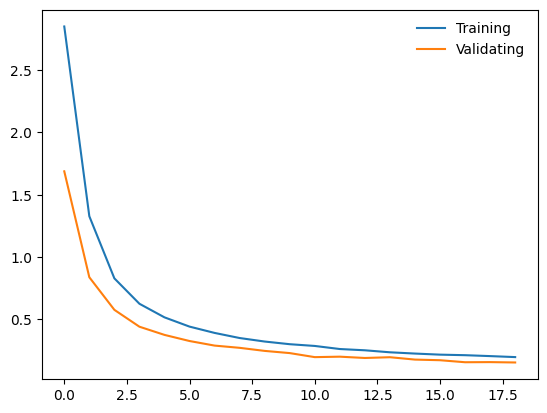

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(train_losses, label="Training")
axes.plot(valid_losses, label="Validating")
axes.legend(frameon=False)

In [20]:
print('train : ')
print(train_losses)
print('val : ')
print(valid_losses)

train : 
[2.850738523873416, 1.3279048346795819, 0.8291808844357729, 0.6253918526118452, 0.516285762143406, 0.44193765697831455, 0.3913433186608282, 0.3503229166821323, 0.3221279679619792, 0.3007073563828387, 0.2867265147648074, 0.2620185276163234, 0.25183668151455507, 0.23578606045466255, 0.22557871329555795, 0.21690576459450478, 0.21254315978762778, 0.20522867020939223, 0.19727000841934403]
val : 
[1.6882678657161947, 0.8381031791774594, 0.5765961568574516, 0.4411603059999797, 0.37547913151127954, 0.3263103891316117, 0.2895942734820502, 0.27164187291446995, 0.2469949428296211, 0.22936846516570267, 0.196924621509198, 0.20062737999369903, 0.19015115569440685, 0.196237961024198, 0.17723732949899776, 0.1721617342638118, 0.15601385089625813, 0.1570090285331315, 0.1540585644809263]


In [4]:
dhcd_model = Network()
dhcd_model.load_state_dict(torch.load("dhcd_model_8_March_2020.pth"))
dhcd_model.eval()

Network(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=25600, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=46, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [7]:
from PIL import Image

In [8]:
input_image = Image.open('test_letter.jpg')

In [9]:
preprocess = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [10]:
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

In [11]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
with torch.no_grad():
    output = dhcd_model(input_batch)
probabilities = F.softmax(output[0], dim=0)

In [12]:
predicted_class = np.argmax(probabilities)

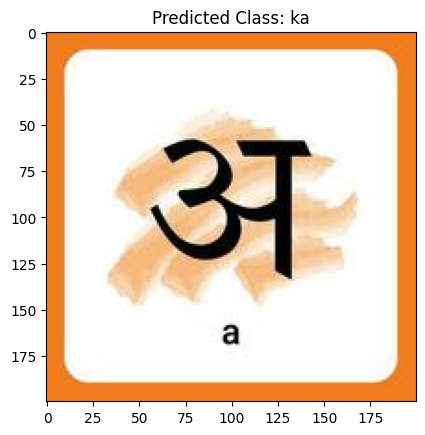

In [14]:
plt.imshow(input_image)
plt.title(f'Predicted Class: ka')
plt.show()